In [46]:
import math
import numpy as np

import matplotlib.pyplot as plt

In [47]:
class Vec2Rot:
    def __init__(self, x:float, y:float, r:float):
        self.x = x
        self.y = y
        self.r = r

    def rotate_xy(self, angle):
        cos_theta = math.cos(angle)
        sin_theta = math.sin(angle)

        new_x = self.x * cos_theta - self.y * sin_theta
        new_y = self.x * sin_theta + self.y * cos_theta

        return Vec2Rot(new_x, new_y, self.r)
    
    def rotate_all(self, angle):
        cos_theta = math.cos(angle)
        sin_theta = math.sin(angle)

        new_x = self.x * cos_theta - self.y * sin_theta
        new_y = self.x * sin_theta + self.y * cos_theta

        return Vec2Rot(new_x, new_y, self.r + angle)

    def __add__(self, other: "Vec2Rot"):
        return Vec2Rot(self.x + other.x, self.y + other.y, self.r + other.r)

    def __sub__(self, other: "Vec2Rot"):
        return Vec2Rot(self.x - other.x, self.y - other.y, self.r - other.r)

    def __mul__(self, scalar: float):
        return Vec2Rot(self.x * scalar, self.y * scalar, self.r * scalar)
    
    def __truediv__(self, scalar: float):
        return Vec2Rot(self.x / scalar, self.y / scalar, self.r / scalar)
    
    def mag(self) -> float:
        return math.sqrt(self.x*self.x+self.y*self.y+self.r*self.r)
    def mag_xy(self) -> float:
        return math.sqrt(self.x*self.x+self.y*self.y)
    
    def normal_or_less(self):
        return self / max(1,self.mag())
    def normal_xy(self):
        if self.mag_xy() == 0: return self
        return self / self.mag_xy()

    def to_numpy(self):
        return np.array([self.x, self.y, self.r])

def lerp_v2r(a: Vec2Rot, b: Vec2Rot, k: float) -> Vec2Rot:
    return a*(1-k) + b*(k)

In [48]:
class PID:
    def __init__(self, p: float, i: float, d: float) -> None:
        self.pid = (p, i, d)
        self.iy = 0
        self.py = 0
        self.dy = 0
    def update(self, y: float, dt: float) -> float:
        self.iy += y * dt
        self.dy = (y - self.py) / dt
        self.py = y

        (p,i,d) = self.pid
        return p*self.py + i*self.iy + d*self.dy

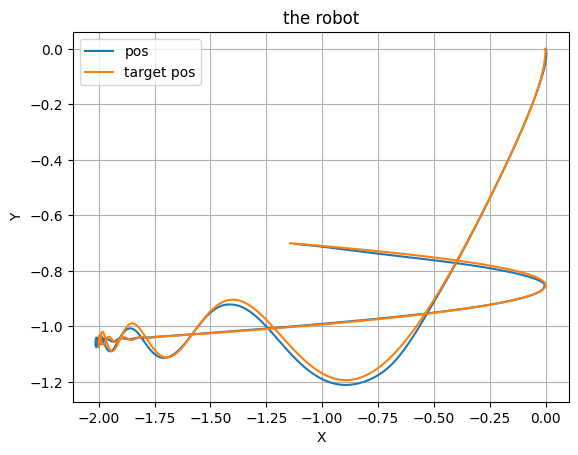

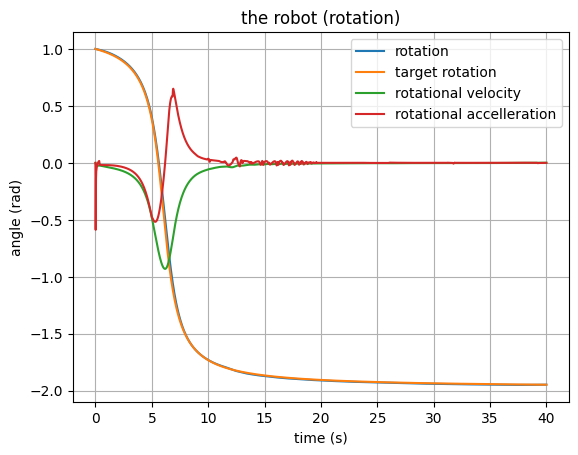

In [102]:
def absub(x: float, y: float):
    r = abs(x) - y
    if r < 0: return 0
    elif x > 0: return r
    else: return -r

class Robot:
    def __init__(self, x: Vec2Rot, v: Vec2Rot, fx: Vec2Rot, fy: Vec2Rot, fr: Vec2Rot, aa: Vec2Rot, isf: float, ikf: float) -> None:
        self.k = Vec2Rot(0,0,0)
        self.x = x
        self.v = v
        self.a = Vec2Rot(0,0,0)
        self.fx = fx
        self.fy = fy
        self.fr = fr
        self.aa = aa
        self.isf = isf
        self.ikf = ikf
        self.raw_power = Vec2Rot(0,0,0)

        # self.accdx = Vec2Rot(0,0,0)

        (p,i,d) = (-0.3, -0.002, -2.0)
        self.pid = (
            PID(p,i,d),
            PID(p,i,d),
        )
    def step(self, dt: float) -> None:
        acceleration_abberation_strength = self.a.mag_xy()
        pv = self.v
        self.raw_power = self.raw_power.normal_or_less()
        self.v += (
            self.fx * absub(self.raw_power.x, self.isf) +
            self.fy * absub(self.raw_power.y, self.isf) +
            self.fr * absub(self.raw_power.r, self.isf) +
            self.aa * acceleration_abberation_strength
        ).rotate_xy(self.x.r) * dt
        self.v *= pow(1-self.ikf,dt)
        self.a = (self.v - pv) / dt
        self.x += self.v * dt
    
    # def set_power_seek(self, dt: float, tx: Vec2Rot, tv: Vec2Rot):
    #     # dx = tx - self.x
    #     # ddv = (self.v.normal_xy() - dx.normal_xy()) * self.v.mag_xy()
    #     # dx = dx * absub(dx.mag_xy(), -5.0)
    #     # dv = Vec2Rot(self.v.x, self.v.y, 0) * 10.1
    #     # dv = tv - self.v
    #     # self.raw_power = (dx - dv - ddv).rotate_xy(-self.x.r)
    #     acceleration_abberation_strength = self.a.mag_xy()
    #     (pid_x, pid_y) = self.pid
    #     self.raw_power = (
    #         # Vec2Rot(
    #         #     pid_x.update(self.x.x - tx.x, dt),
    #         #     pid_y.update(self.x.y - tx.y, dt),
    #         #     0.0
    #         # )
    #         (tx - self.x) - self.v
    #         - self.aa * acceleration_abberation_strength * 1.6
    #     ).rotate_xy(-self.x.r)
    def set_pow_reactive(self, tx: Vec2Rot, tv: Vec2Rot, ta: Vec2Rot, aa_predicted: Vec2Rot, dt: float):
        self.k += (self.x - tx) * dt
        self.k *= 0.5 ** dt
        k = self.k
        i = self.x - tx
        p = self.v - tv
        d = self.a - ta
        # i = self.accdx

        acceleration_abberation_strength = (self.a).mag_xy()
        self.raw_power = (
            Vec2Rot(0,0,0)
            # - i * 3.5
            # - p * 7.5
            # - d * 0.1
            - k * 5.0
            - i * 15.5
            - p * 10
            # - d * 0.05
            # - aa_predicted * acceleration_abberation_strength * 1.3
        ).rotate_xy(-self.x.r)


r = Robot(
    Vec2Rot(0,0,1.0),
    Vec2Rot(0,0,0),
    Vec2Rot(1.02, 0.1, -0.002),
    Vec2Rot(-0.3, 1.1, -.012),
    Vec2Rot(0.03, 0, 3.3),
    Vec2Rot(0.7,-0.4,-0.3),
    # 0.1,
    # 0.2,
    0.1,
    # 0.4,
    0.9,
)

def plot_vec2rot(x: list[Vec2Rot], v: list[Vec2Rot], a: list[Vec2Rot], tx: list[Vec2Rot], ts: list[float]):

    plt.plot([vec.x for vec in x], [vec.y for vec in x]) #, "+")
    plt.plot([vec.x for vec in tx], [vec.y for vec in tx])
    # plt.plot([vec.x for vec in v], [vec.y for vec in v]) #, "+")
    # plt.plot([vec.x for vec in a], [vec.y for vec in a]) #, "+")
    plt.legend([
        "pos",
        "target pos",
        # "velocity",
        # "acceleration",
    ])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('the robot')
    plt.grid(True)
    plt.show()

    plt.plot(ts, [(vec.r + math.pi) % math.tau - math.pi for vec in x])
    plt.plot(ts, [(vec.r + math.pi) % math.tau - math.pi for vec in tx])
    plt.plot(ts, [(vec.r + math.pi) % math.tau - math.pi for vec in v])
    plt.plot(ts, [(vec.r + math.pi) % math.tau - math.pi for vec in a])
    plt.legend([
        "rotation",
        "target rotation",
        "rotational velocity",
        "rotational accelleration",
    ])
    plt.xlabel('time (s)')
    plt.ylabel('angle (rad)')
    plt.title('the robot (rotation)')
    plt.grid(True)
    plt.show()

ts: list[float] = []
txs: list[Vec2Rot] = []
xs: list[Vec2Rot] = []
vs: list[Vec2Rot] = []
as_: list[Vec2Rot] = []
txs: list[Vec2Rot] = []

DT = 0.01
def gtx(t: float):
    return Vec2Rot(
        math.cos(t/5),
        math.sin(math.exp(t/5-0.4) * math.pi / 2)*max(0,math.exp(-t/5)-0.02) - math.sin(t/10) / 5,
        -min(math.atan(t-6),math.pi)
    )
def gtv(t: float):
    return (gtx(t + DT) - gtx(t - DT)) / (DT * 2)
def gta(t: float):
    return (gtv(t + DT) - gtv(t - DT)) / (DT * 2)

    # K = 1.5
    # T = 1/5
    # tx = Vec2Rot(
    #     K*(k*k*T/2-k*k*k*T*T/3),
    #     k*k*T/2,
    #     0,
    # )
    # tv = Vec2Rot((k*T)*(1-k*T)*K,k*T,0)
    # ta = Vec2Rot(K*((k*T)*(-T) + (T)*(1-k*T)),T,0)
pos_init = r.x
t = 0
for i in range(0,4000):
    dt = 0.01
    t = i * dt
    ts.append(t)

    xs.append(r.x)
    vs.append(r.v)
    as_.append(r.a)
    
    tx = gtx(t) - gtx(0) + pos_init
    tv = gtv(t)
    ta = gta(t)
    
    txs.append(tx)

    r.set_pow_reactive(tx, tv, ta, r.aa, dt)
    r.step(dt)
plot_vec2rot(xs, vs, as_, txs, ts)


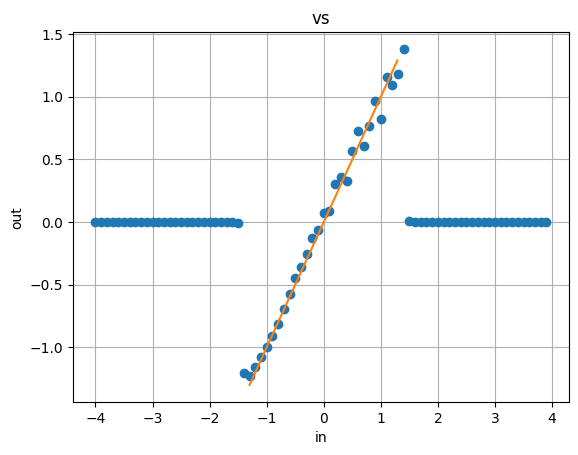

In [50]:
import random
def rng_pn():
    return (random.random() * 2 - 1)
def test_calibration(abbr: Vec2Rot):
    ks: list[(float,float)] = []
    for i in range(0, 1):
        r = Robot(
            Vec2Rot(0,0,0),
            Vec2Rot(0,0,0),
            Vec2Rot(1 + rng_pn() * 0.3, rng_pn() * 0.1, rng_pn() * 0.1),
            Vec2Rot(rng_pn() * 0.1, 1 + rng_pn() * 0.3, rng_pn() * 0.1),
            Vec2Rot(rng_pn() * 0.1, rng_pn() * 0.1, 2+rng_pn()*1.0),
            abbr,
            0.02+random.random()*0.2,
            0.9,#+rng_pn()*0.3,
        )
        DT = 0.02
        # drive on x and measure
        xs_x: list[Vec2Rot] = []
        vs_x: list[Vec2Rot] = []
        as_x: list[Vec2Rot] = []
        r.x = Vec2Rot(0,0,0)
        r.v = Vec2Rot(0,0,0)
        r.a = Vec2Rot(0,0,0)
        r.raw_power = Vec2Rot(1,0,0)
        for _ in range(0,int(5/DT),1):
            xs_x.append(r.x)
            vs_x.append(r.v)
            as_x.append(r.a)
            r.step(DT)
            r.x.r = 0
            r.v.r = 0

        # drive on y and measure
        xs_y: list[Vec2Rot] = []
        vs_y: list[Vec2Rot] = []
        as_y: list[Vec2Rot] = []
        r.x = Vec2Rot(0,0,0)
        r.v = Vec2Rot(0,0,0)
        r.a = Vec2Rot(0,0,0)
        r.raw_power = Vec2Rot(0,1,0)
        for _ in range(0,int(5/DT),1):
            xs_y.append(r.x)
            vs_y.append(r.v)
            as_y.append(r.a)
            r.step(DT)
            r.x.r = 0
            r.v.r = 0

        # xs_x = [xs_x[i].rotate_all(-xs_x[i].r) for i in range(2,len(xs_x))]
        # vs_x = [vs_x[i].rotate_xy(-xs_x[i].r) for i in range(2,len(xs_x))]
        # as_x = [as_x[i].rotate_xy(-xs_x[i].r) for i in range(2,len(xs_x))]
        # xs_y = [xs_y[i].rotate_all(-xs_y[i].r) for i in range(2,len(xs_y))]
        # vs_y = [vs_y[i].rotate_xy(-xs_y[i].r) for i in range(2,len(xs_y))]
        # as_y = [as_y[i].rotate_xy(-xs_y[i].r) for i in range(2,len(xs_y))]

        ks.append((
            as_y[4].x / as_y[4].y / (1-vs_y[-1].x/vs_y[-1].y) ** 2,
            as_x[4].y / as_x[4].x / (1-vs_x[-1].y/vs_x[-1].x) ** 2,
        ))
    # # plt.plot([vec.x for vec in ras_x], [vec.y for vec in ras_x])
    # # plt.plot([vec.x for vec in ras_y], [vec.y for vec in ras_y])
    # # plt.plot([vec.x for vec in vs_x], [vec.y for vec in vs_x])
    # # plt.plot([vec.x for vec in vs_y], [vec.y for vec in vs_y])
    # plt.plot([vec.x for vec in xs_x], [vec.y for vec in xs_x])
    # plt.plot([vec.x for vec in xs_y], [vec.y for vec in xs_y])
    # # plt.plot([vec.x for vec in vs_x[1:]], [vec.y for vec in vs_x[1:]])
    # # plt.plot([vec.x for vec in vs_y[1:]], [vec.y for vec in vs_y[1:]])
    # # plt.plot([vec.x for vec in as_x[3:]], [vec.y for vec in as_x[3:]])
    # # plt.plot([vec.x for vec in as_y[3:]], [vec.y for vec in as_y[3:]])
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.title('the accelleration')
    # plt.grid(True)
    # plt.show()
        

    # plt.plot([x for (x,_) in ks], [y for (_,y) in ks], "o")
    # plt.xlabel('x')
    # plt.ylabel('y')
    # plt.title('the accelleration')
    # plt.ylim(-2,2)
    # plt.xlim(-2,2)
    # plt.grid(True)
    # plt.show()

    ksxs = 0
    ksys = 0
    for k in ks:
        ksxs += k[0]
        ksys += k[1]
    return Vec2Rot(
        math.atan(ksxs / len(ks)), # ks[0][0],# - rvs_y[-1].x / rvs_y[-1].mag_xy(),
        math.atan(ksys / len(ks)), # ks[0][1],# - rvs_x[-1].y / rvs_x[-1].mag_xy(),
        0,
    )


def calibrate_robot(r: Robot):
    DT = 0.02
    # drive on x and measure
    xs_x: list[Vec2Rot] = []
    vs_x: list[Vec2Rot] = []
    as_x: list[Vec2Rot] = []
    r.x = Vec2Rot(0,0,0)
    r.v = Vec2Rot(0,0,0)
    r.a = Vec2Rot(0,0,0)
    r.raw_power = Vec2Rot(1,0,0)
    for _ in range(0,int(5/DT),1):
        xs_x.append(r.x)
        vs_x.append(r.v)
        as_x.append(r.a)
        r.step(DT)
        r.x.r = 0
        r.v.r = 0

    # drive on y and measure
    xs_y: list[Vec2Rot] = []
    vs_y: list[Vec2Rot] = []
    as_y: list[Vec2Rot] = []
    r.x = Vec2Rot(0,0,0)
    r.v = Vec2Rot(0,0,0)
    r.a = Vec2Rot(0,0,0)
    r.raw_power = Vec2Rot(0,1,0)
    for _ in range(0,int(5/DT),1):
        xs_y.append(r.x)
        vs_y.append(r.v)
        as_y.append(r.a)
        r.step(DT)
        r.x.r = 0
        r.v.r = 0
    
    r.x = Vec2Rot(0,0,0)
    r.v = Vec2Rot(0,0,0)
    r.a = Vec2Rot(0,0,0)

    return Vec2Rot(
        math.atan(as_y[4].x / as_y[4].y / (1-vs_y[-1].x/vs_y[-1].y) ** 2),
        math.atan(as_x[4].y / as_x[4].x / (1-vs_x[-1].y/vs_x[-1].x) ** 2),
        0,
    )

dxs: list[float] = []
for i in range(-40,40):
    dxs.append(test_calibration(Vec2Rot(i/10,0.0,0.0)).x)

plt.plot([x/10 for x in range(-40,40)], [x for x in dxs], "o")
# # plt.plot([x/100 for x in range(-150,150)], [math.exp(x)-1 for x in [x/100 for x in range(-150,150)]])
# plt.plot([x/100 for x in range(-130,130)], [math.tan(x) for x in [x/100 for x in range(-130,130)]])
plt.plot([x/100 for x in range(-130,130)], [x/100 for x in range(-130,130)])
plt.xlabel('in')
plt.ylabel('out')
plt.title('vs')
plt.grid(True)
plt.show()




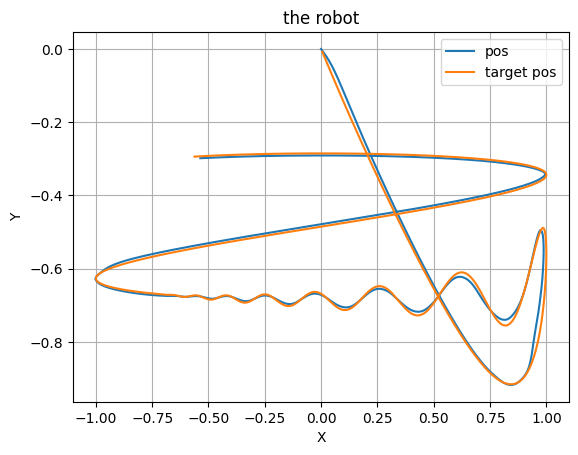

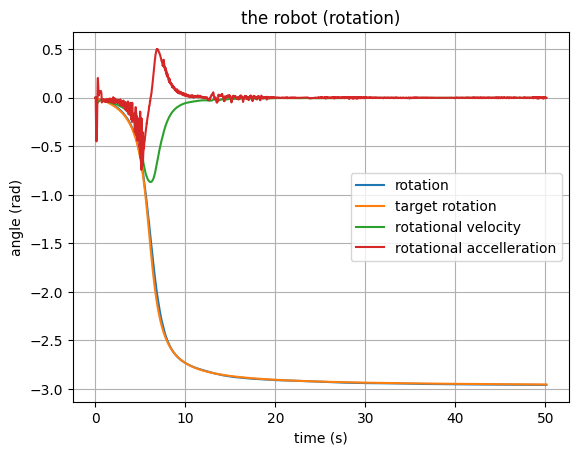

In [103]:

r = Robot(
    Vec2Rot(0,0,0),
    Vec2Rot(0,0,0),
    Vec2Rot(1.02, 0.1, -0.002),
    Vec2Rot(-0.3, 1.1, -.012),
    Vec2Rot(0.03, 0, 3.3),
    Vec2Rot(0.7,-0.4,-0.3),
    # 0.1,
    # 0.2,
    0.1,
    # 0.4,
    0.95,
)
aa_predicted = calibrate_robot(r)

ts: list[float] = []
txs: list[Vec2Rot] = []
xs: list[Vec2Rot] = []
vs: list[Vec2Rot] = []
as_: list[Vec2Rot] = []
txs: list[Vec2Rot] = []

DT = 0.01
def gtx(t: float):
    return Vec2Rot(
        math.sin(t/5),
        math.cos(math.exp(t/5-0.4) * math.pi / 2)*max(0,math.exp(-t/5)-0.02) - math.sin(t/10) / 5,
        -min(math.atan(t-6),math.pi)
    )
def gtv(t: float):
    return (gtx(t + DT) - gtx(t - DT)) / (DT * 2)
def gta(t: float):
    return (gtv(t + DT) - gtv(t - DT)) / (DT * 2)

t = 0
pos_init = r.x
for i in range(0,2000):
    dt = 0.01*random.random()+0.02
    t += dt
    ts.append(t)

    xs.append(r.x)
    vs.append(r.v)
    as_.append(r.a)
    
    tx = gtx(t) - gtx(0) + pos_init
    tv = gtv(t)
    ta = gta(t)
    
    txs.append(tx)

    r.set_pow_reactive(tx, tv, ta, aa_predicted, dt)
    r.step(dt)

plot_vec2rot(xs, vs, as_, txs, ts)